# From FEA to Graph data

In this notebook, we'll go through the process of running a finite element analysis (FEA) simulation using FEBio, a specialized software for biomechanics and FEA. After running the simulation, we’ll load the results, visualize them using Pyvista, and finally convert the data to graph format with PyTorch Geometric (PyG), preparing it for use with graph neural networks (GNNs).

## Required Modules and Installation

This notebook relies on three main Python libraries for finite element analysis (FEA), graph representation, and visualization:

1. **febio_python**: This library provides Python bindings for FEBio, a software specifically designed for nonlinear FEA, especially in biomechanics. `febio_python` allows us to run FEBio simulations directly from Python and simplifies the process of handling FEBio files.
   - **Installation**: Run `pip install febio-python`
   - **Documentation**: [febio-python GitHub repository](https://github.com/Nobregaigor/febio-python)

2. **PyTorch Geometric (PyG)**: PyG is a library built on top of PyTorch to handle graph data in deep learning applications. We use it to represent the FEA results as graphs and to prepare the data for graph neural network (GNN) training.
   - **Installation**: PyG has specific installation instructions depending on your operating system and CUDA version. Basic installation can be done with:
     ```
     pip install torch_geometric
     ```
   - **Documentation**: [PyTorch Geometric Documentation](https://pytorch-geometric.readthedocs.io/en/latest/index.html)

3. **Pyvista**: Pyvista is a 3D visualization library for Python, well-suited for visualizing FEA results and other scientific data. It supports easy rendering and mesh manipulation, allowing us to visualize stress, displacement, and other simulation outputs.
   - **Installation**: Run `pip install pyvista`
   - **Documentation**: [Pyvista Documentation](https://docs.pyvista.org/)

We also require other libraries, like `numpy` and `pytorch`

Ensure these libraries are installed and configured in your environment before proceeding. This notebook will use them extensively for running simulations, handling FEA data, and preparing inputs for GNNs.

## Running the FEB file

### Step 1: Locate the FEB Files to Run

The first step is to find the `.feb` files (FEBio input files) in the current directory. 
The `Path` object will search for and list all files with the `.feb` extension, sorting them to ensure consistent ordering.

In [1]:
from pathlib import Path
files_to_run = sorted(list(Path("./").glob("*.feb")))  # Find all .feb files in the current directory
files_to_run

[WindowsPath('sample.feb')]

### Step 2: Run the Simulation with FEBio

Now, we’ll use `febio_python` to execute the FEA simulations on the located `.feb` files.
Each `.feb` file represents a simulation setup, and we can specify the number of parallel processes for faster execution.
Here, `num_processes=1` means each simulation will run sequentially. You can increase the number of processes to run simulations in parallel.

In [2]:
from febio_python import run

run(files_to_run, num_processes=1)  # Run all the .feb files in the current directory

Starting process for: sample.feb
Waiting for process to complete...
Completed process for: sample.feb


## Loading Simulation Results with Pyvista

After running the simulations, the next step is to load and visualize the results. We’ll use `Pyvista`, a 3D visualization library for scientific data, to view the simulation output.

### Step 1: Load the Results into Pyvista

Here, we convert the first result file from the simulation (i.e., the first `.feb` file) to Pyvista format using `febio_to_pyvista`. 
This format allows for straightforward visualization and interaction with the data.

In [3]:
from febio_python.utils.pyvista_utils import febio_to_pyvista

result = febio_to_pyvista(files_to_run[0])  # Load the first result file

### Step 2: Inspect the Loaded Results

Each result typically includes multiple "states" or "steps" representing different time steps in the simulation. 
Here, we print the total number of states and display a sample (the last state) to get a quick overview of the data structure.

In [4]:
print(f"Number of states: {len(result)}")  # Print the number of states
print(f"Sample:")  # Print the first state
result[-1]

Number of states: 11
Sample:


UnstructuredGrid (0x23aba6e8e20)
  N Cells:    216
  N Points:   133
  X Bounds:   0.000e+00, 2.831e+00
  Y Bounds:   -1.406e+00, 1.000e+00
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   24

### Step 3: Visualize Stress and Displacement Fields

Using Pyvista, we can visualize the stress and displacement fields of the simulation. We’ll display these fields side-by-side:
- The left panel shows the "stress" field with edges, which helps visualize stress distribution in the mesh.
- The right panel shows the "displacement" field, also with edges.
- Views are linked to stay synchronized, and the perspective is set to the XY plane.


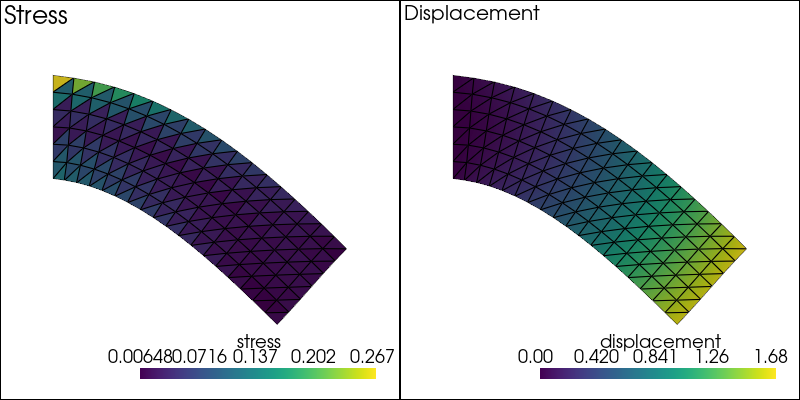

In [5]:
import pyvista as pv
pv.set_jupyter_backend("static")  # Set the jupyter backend to static

plotter = pv.Plotter(notebook=True, shape=(1, 2), window_size=[800, 400])
plotter.subplot(0, 0)
plotter.add_mesh(result[-1], scalars="stress", show_edges=True)
plotter.add_text("Stress", font_size=10)
plotter.subplot(0, 1)
plotter.add_mesh(result[-1], scalars="displacement", show_edges=True)
plotter.add_text("Displacement", font_size=10)
plotter.link_views()
plotter.view_xy()
plotter.show()

# Converting Simulation Results to Graph Data with PyTorch Geometric

To prepare for training a graph neural network (GNN), we need to convert the simulation data into a format compatible with PyTorch Geometric (PyG). 
In this section, we’ll take each state of the simulation and represent it as a graph, where nodes hold information about position, stress, displacement, and other key attributes.


Workflow Outline
- Convert each mesh state to a graph by representing each node with specific attributes.
- Define edges by connecting nodes within mesh cells and computing their edge attributes, such as direction and magnitude.
- Store each state as a separate `Data` object in a list, making it easy to work with for GNN-based training or analysis.


Key attributes in each `Data` object:
- `pos`: The position of each point (node) in the mesh for the current state.
- `initial_pos`: The reference positions from the initial state, which provide context for tracking changes.
- `displacement`: Displacement values at each node.
- `stress`: Stress values at each node.
- `nodal_load`: The load applied at each node.
- `edge_index`: Index of edges that define connections between nodes.
- `edge_attr`: Attributes of each edge, including direction and magnitude, calculated using initial positions.


### Step 1: Define Functions to Extract Edges and Edge Attributes

First, we define helper functions to:
- Break down mesh cells into edges that will connect nodes in the graph.
- Compute edge attributes (direction vectors and magnitudes) based on initial node positions, as these provide useful information for deformation analysis.


- **`break_elements_into_edges`**:
  - This function accepts `elements` (the mesh cell data) and `cell_type` (e.g., triangles or quads) to define edges. Each edge is represented by a pair of node indices, which are then made undirected for graph compatibility.

- **`create_edge_attr`**:
  - This function calculates the edge vectors (differences between node positions) and their magnitudes, normalizing each vector and then combining it with its magnitude to produce edge attributes.


In [6]:
import numpy as np
import torch
from torch_geometric.utils import to_undirected

def break_elements_into_edges(elements: np.ndarray, cell_type: pv.CellType) -> torch.Tensor:
    # break elements into list of edges
    if cell_type == pv.CellType.TRIANGLE or str(cell_type).upper() == "TRIANGLE":
        edges = np.concatenate(
            [elements[:, [0, 1]], elements[:, [1, 2]], elements[:, [2, 0]]])
    elif cell_type == pv.CellType.QUAD or str(cell_type).upper() == "QUAD":
        edges = np.concatenate(
            [elements[:, [0, 1]], elements[:, [1, 2]], 
             elements[:, [2, 3]], elements[:, [3, 0]]])
    # transpose to make it COO format
    edges = edges.T
    # Convert to torch tensor
    edges = torch.tensor(edges, dtype=torch.long)
    # Convert to undirected edges (i.e. no order)
    edges = to_undirected(edges)
    return edges

In [7]:
def create_edge_attr(edges: torch.Tensor, node_pos: torch.Tensor) -> torch.Tensor:
    # Simply use edges as vectors
    src, dst = edges
    vectors = node_pos[dst] - node_pos[src]
    vectors_mag = torch.norm(vectors, dim=1).view(-1, 1)
    vectors_normed = vectors / vectors_mag
    return torch.cat([vectors_normed, vectors_mag], dim=1)  # (N, 4)

### Step 2: Convert Mesh Data to Graph Format

Next, we create a function `pyvista_to_graph`, which takes in a `mesh` (state in the simulation), `initial_state` (undeformed reference state), and `cell_type` to convert the mesh to a graph.

Here’s what `pyvista_to_graph` does:
- **Convert Cell Data to Point Data**:
  - Cell data (e.g., stress) is first converted to point data, as graphs operate on nodes rather than mesh cells. Pyvista averages cell data at each node to make this transformation. Note that existing point data (e.g. displacement) is not modified.

- **Define Edges**:
  - Edges between nodes are computed by breaking down the mesh cells into pairs of connected nodes using `break_elements_into_edges`.

- **Compute Edge Attributes**:
  - Using the initial node positions as a reference, we calculate the edge vectors and their magnitudes with `create_edge_attr`. These attributes (direction and magnitude) provide critical information about the structure and deformation of the mesh, which is useful for training GNNs.

- **Create Data Object**:
  - The processed data (node attributes, edges, and edge attributes) are then structured into a `Data` object, ready for graph-based analysis.


In [8]:
from torch_geometric.data import Data

def pyvista_to_graph(mesh: pv.UnstructuredGrid, initial_state: pv.UnstructuredGrid, cell_type: pv.CellType) -> Data:
    # first, convert all the cell data (e.g. stress) to point data
    # pyvista simply averages the cell data to the points
    point_mesh = mesh.cell_data_to_point_data(pass_cell_data=False)
    # Next, compute the edges
    edges = break_elements_into_edges(mesh.cells_dict[cell_type], cell_type)
    # since we want to predict the current state, we will use the initial points as reference for the edge attributes
    edge_attr = create_edge_attr(edges, torch.from_numpy(initial_state.points))
    # Finally, create the graph
    data = Data(
        edge_index=edges,
        edge_attr=edge_attr,
        pos=point_mesh.points,
        initial_pos=initial_state.points,
        displacement=point_mesh["displacement"],
        stress=point_mesh["stress"],
        nodal_load=point_mesh["nodal_load"],
    )
    return data

### Step 3: Create Graphs for Each Simulation State

We iterate through each state in `result` and apply `pyvista_to_graph` to convert it into a `Data` object.
The resulting list `results_as_graphs` contains graph representations for each simulation step, each ready to be used for GNN-based modeling or further analysis.


In [9]:
results_as_graphs = [pyvista_to_graph(state, result[0], pv.CellType.TRIANGLE) for state in result]

### Verification

Display the first graph data object to confirm that the conversion has worked as expected.
This `Data` object should include the required attributes (position, stress, displacement, etc.) and be formatted correctly for GNN applications.

In [10]:
results_as_graphs[0]

Data(edge_index=[2, 696], edge_attr=[696, 4], pos=[133, 3], initial_pos=[133, 3], displacement=[133, 3], stress=[133, 6], nodal_load=[133, 3])